# Задание

На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

1. В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
2. Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый

Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

Задания:
1. Выберите метод, который предположительно подойдет в первом вопросе.
2. Проверьте, являются ли дисперсии внутри групп гомогенными.
3. Проведите тест на нормальность распределения.
4. Сравните средние в представленных группах.
5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 
6. Примите решение: какие картинки в итоге будем использовать?
7. Выберите метод для второго теста.
8. Визуализируйте распределение events для контрольной и тестовой групп. 
9. Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 
10. Выберите формулу для модели, проведите тест.

Описание данных

5_task_1:

1. id – id клиента в эксперименте
2. group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
3. events – сколько блюд суммарно было заказано за период

5_task_2:

1. id – id клиента в эксперименте
2. segment – сегмент (high/low)
3. group – вид кнопки (control – старая версия, test – новая версия)
4. events – сколько блюд суммарно было заказано за период

In [17]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy.stats import levene
from scipy import stats
from scipy.stats import norm
import seaborn as sns, numpy as np
import scipy
from scipy.stats import f_oneway

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
#загрузили файлы
df_1 = pd.read_csv('5_task_1.csv')
df_2 = pd.read_csv('5_task_2.csv')

In [19]:
df_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [20]:
df_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [21]:
df_1.info()
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30000 non-null  int64 
 1   group   30000 non-null  object
 2   events  30000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 703.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  int64  
 1   group    100000 non-null  object 
 2   segment  100000 non-null  object 
 3   events   100000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


# Задача 1

1. Выберите метод, который предположительно подойдет в первом вопросе.

Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

1. A – прямоугольные 16:9
2. B – квадратные
3. C – прямоугольные 12:4

In [22]:
# Будем использовать статистический тест ANOVA


# Задача 2

Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [23]:
#создаем три отдельных массива для дальнейшей проверки на гомогенность дисперсий
group_a = df_1.query('group == "A"').events
group_b = df_1.query('group == "B"').events
group_c = df_1.query('group == "C"').events

In [24]:
#проверка на гомогенность дисперсий. pvalue > 0.05, поэтому нулевую гипотезу не отклоняем. тест Левена
levene(group_a, group_b, group_c)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

# Задача 3

Проведите тест на нормальность распределения.

In [25]:
#провели сэмплирования для дальнейшей проверки на нормальность по тесту Шапиро-Уилка
test_a = df_1[df_1['group'] == 'A']['events'].sample(1000, random_state=17)
test_b = df_1[df_1['group'] == 'B']['events'].sample(1000, random_state=17)
test_c = df_1[df_1['group'] == 'C']['events'].sample(1000, random_state=17)

In [26]:
#уровень значимости больше 5%, поэтому нулевую гипотезу (распределение нормальное) не отклоняем
stats.shapiro(test_a)


ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [27]:
#уровень значимости больше 5%, поэтому нулевую гипотезу (распределение нормальное) не отклоняем
stats.shapiro(test_b)

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

In [28]:
#уровень значимости больше 5%, поэтому нулевую гипотезу (распределение нормальное) не отклоняем
stats.shapiro(test_c)

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

# Задача 4

Сравните средние в представленных группах.

In [29]:
#провели однофакторный дисперсионный анализ
f_oneway(group_a, group_b, group_c)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

# Задача 5

Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 

In [30]:
#Теперь используем критерий Тьюки и определим, между какими группами есть статистически значимые различия. 
# влияние определяем по meandiff
tukey_test = pairwise_tukeyhsd(df_1.events, df_1.group).summary()
tukey_test

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


# Задача 6

Примите решение: какие картинки в итоге будем использовать?

In [31]:
# тк наибольшим положительный различием обладает пара A - B, тогда выбираем вариант B.

# Задача 7

Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

Какой метод скорее всего пригодится в данном случае?

In [32]:
# необходимо использовать многофакторный дисперсионный анализ

# Задача 9

Визуализируйте распределение events для контрольной и тестовой групп. 

In [33]:
#работаем со вторым файлом
df_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [34]:
#разделяем на 2 таблицы: данные по тестовым и контрольным показателям
df_test = df_2.query('group == "test"')
df_control = df_2.query('group == "control"')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


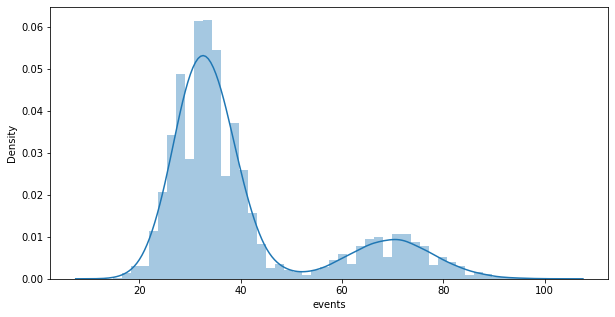

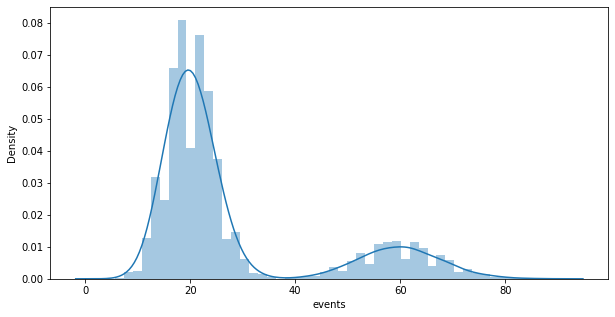

In [36]:
#строим график тестового распределения
plt.figure(figsize=(10, 5))
sns.distplot(df_test.events)
#строим график контрольного распределения
plt.figure(figsize=(10, 5))
sns.distplot(df_control.events)

# Задача 9

Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 

In [37]:
#выводим статистику по сгруппированным данным: группа и сегмент
df_2.groupby(['group', 'segment']).describe()

id                                                     \
                   count        mean           std   min       25%      50%   
group   segment                                                               
control high     10000.0  50473.9782  28761.438914  10.0  25612.50  51031.0   
        low      40000.0  49935.2567  28855.849243   0.0  25022.25  49944.5   
test    high     10000.0  50126.6206  28821.133487  14.0  25317.50  50234.5   
        low      40000.0  49913.3436  28917.383492   1.0  24763.75  49706.5   

                                     events                                   \
                      75%      max    count       mean       std   min   25%   
group   segment                                                                
control high     75261.25  99976.0  10000.0  59.970800  7.805347  31.0  55.0   
        low      74874.25  99999.0  40000.0  20.031575  4.473576   4.0  17.0   
test    high     74783.25  99996.0  10000.0  69.938500  8.403974  40.0  64.0   
        low      75127.25  99995.0  40000.0  33.025925  5.720845  13.0  29.0   

                                    
                  50%   75%    max  
group   segment                     
control high     60.0  65.0   89.0  
        low      20.0  23.0   41.0  
test    high     70.0  76.0  102.0  
        low      33.0  37.0   59.0

# Задачи 9-10

Выберите формулу для модели, проведите тест.

In [42]:
df_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [43]:
#проверим эффект нескольких переменных – group и segment – на events, с взаимодействием факторов
model_main = smf.ols("events ~ C(group) * C(segment)", data=df_2).fit()
anova_lm(model_main, typ = 2)

,sum_sq,df,F,PR(>F)
C(group),3.837195e+06,1.0,112031.864119,0.000000e+00
C(segment),2.362480e+07,1.0,689756.377484,0.000000e+00
C(group):C(segment),3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [44]:
#создали дубль таблицы, добавили новый столбец с комбинациям группы и сегмента
df_2_new = df_2
df_2_new['combination'] = df_2.group +  ' / '  + df_2.segment

In [45]:
#Теперь используем критерий Тьюки и определим, между какими группами есть статистически значимые различия. 
# влияние определяем по meandiff
tukey_test_df_2 = pairwise_tukeyhsd(df_2_new.events, df_2_new.combination).summary()
tukey_test_df_2

group1,group2,meandiff,p-adj,lower,upper,reject
control / high,control / low,-39.9392,0.001,-40.1073,-39.7711,True
control / high,test / high,9.9677,0.001,9.7551,10.1803,True
control / high,test / low,-26.9449,0.001,-27.113,-26.7768,True
control / low,test / high,49.9069,0.001,49.7388,50.075,True
control / low,test / low,12.9944,0.001,12.888,13.1007,True
test / high,test / low,-36.9126,0.001,-37.0807,-36.7445,True


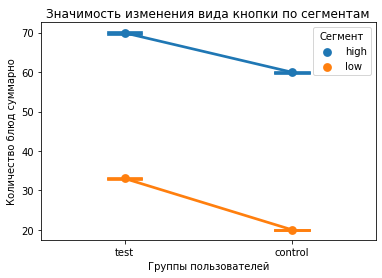

In [46]:
#визуализировали измениния
sns.pointplot(x = 'group', y = 'events', hue = 'segment', data = df_2_new, capsize = .2)
plt.title('Значимость изменения вида кнопки по сегментам')
plt.xlabel('Группы пользователей')
plt.ylabel('Количество блюд суммарно')
plt.legend(title = 'Сегмент')

In [47]:
# Разница между control и test по обоим сегментам составила около 10
# Для обоих сегментов показатели статистически значимо увеличились по сравнению с контрольной группой
# Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13